# Question 1

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [11]:
np.random.seed(0)
seeds = np.random.randint(1, 5562, 50)

In [12]:
seeds

array([2733, 2608, 1654, 3265, 4932, 4860, 1034, 4374, 3469,  706, 2600,
       2136, 2223, 2898, 1702,  538, 2894, 2164, 5073, 4852, 2047, 1872,
       2497,  100, 2009,  756,  798,  660, 3220,  424, 3338, 2746, 4736,
        545,  715, 2293,  152, 2724, 3532, 2931, 1208,  803, 2177, 2177,
       1957, 3623, 3561,  757, 4370, 4485])

In [13]:
class env:
	
	def __init__(self):
		self.state = 0.5
		self.state_space = [0.0,1.0]
		self.action_space = [-0.2, 0.2]
		self.reward = 0
		self.done = False
		
	def step(self):
		action = np.random.uniform(self.action_space[0], self.action_space[1])
		
		if self.done == False:
			self.state += action
		
		if self.state > self.state_space[1] or self.state < self.state_space[0]:
			self.done = True
			self.reward = self.state
			
		return self.state, self.reward, self.done
		
	def reset(self):
		self.state = 0.5
		self.done = False
		self.reward = 0
		
		return self.state

In [14]:
def create_tiles(state_space, bins = 10, n = 10):
	
	tile_width = (state_space[1] - state_space[0])/bins
	offsets = np.random.uniform(0, tile_width, bins)
# 	offsets = np.random.random_sample(bins) * tile_width
	tilings = [np.linspace(state_space[0], state_space[1] + tile_width, num=bins+2) - offsets[i] for i in range(0, bins)]
	
	return tilings, offsets, tile_width

In [15]:
# Turn a given state into a feature vector
# This function gets the state, the created tilings and the number of bins
def get_features(state, tilings, width, bins = 10):
	
	# Create an zero 2D array of shape ( number of tilings, number of bins in each tiling )
	features = np.zeros((len(tilings), bins+1))
    
	# for all tilings
	for i in range(0, len(tilings)):
		
		# Get the current tiling
		t = tilings[i]
		
		# See where the state falls in the tiling by using : (state - min(tiling)) / tiling_width
		# See where the state falls in the tiling by using : (state - min(tiling)) / tiling_width
		index = math.floor((state - np.min(t))/width)
# 		if not(index < 0 or index >= bins+1):
		# Special case for when the state is  max(tiling) ??
#		if index == bins + 1:
#			index = bins
		
		# Set the corresponding feature to 1
		features[i, index] = 1
		
	return features

In [16]:
states = np.linspace(0,1, num = 21)
alphas = np.linspace(0,1, num = 101)
lambdas = np.linspace(0,1, num = 11)
data = np.zeros((len(lambdas),len(alphas), len(seeds)))
gamma = 1.0

In [17]:
alphas

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [19]:
b = time.perf_counter()
# for each lambda
for l, lambd in enumerate(lambdas):
    # for each alpha
    for a, alpha in enumerate(alphas): 
        # for each seed
        for run in range(0, len(seeds)):
            
            # set the seed for each run
            np.random.seed(seeds[run])

            # get the environment
            rw = env()

            # create the tilings
            t , o , width = create_tiles(rw.state_space)
            
            # initialize the weight vector
            w = np.zeros(110)
            
            # do 25 episodes of TD(lambda)
            for episode in range(0,25):
                rw.reset()
                z = np.zeros(110)

                while( 1 ):

                    s = rw.state
                    s_prime , r, _ = rw.step()

                    x_s = get_features(s, t, width).flatten()
                    V_hat_s = np.dot(w, x_s)

                    if rw.done:
                        x_s_prime = np.zeros(110)
                    else:
                        x_s_prime = get_features(s_prime, t, width).flatten()
                        
                    V_hat_s_prime = np.dot(w, x_s_prime)

                    z = gamma*lambd*z + x_s
                    delta = r + gamma*V_hat_s_prime - V_hat_s
                    w = w + alpha*delta*z

                    if rw.done == True:
                        break
            
            # after each run get the MSVE and save it
            vectorized_states = [get_features(states[i], t, width) for i in range(0, len(states))]
            estimated_values = [np.dot(w, vectorized_states[i].flatten()) for i in range(0,len(states))]
            data[l, a, run] = np.sqrt(np.mean((states - estimated_values)**2))
            
e = time.perf_counter()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in add
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in double_scalars


In [20]:
print(f" {(e - b)/60:0.4f} minutes")

 62.4094 minutes


/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


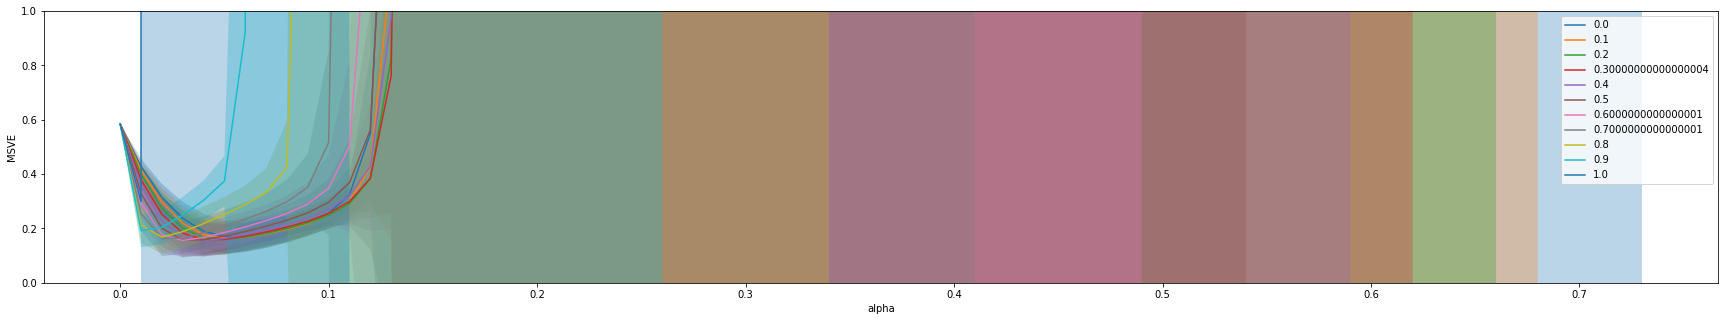

In [21]:
f, axes = plt.subplots(1, 1, figsize=(30, 5))

plt.ylim(top=1) #ymax is your value
plt.ylim(bottom=0) #ymin is your value
for i in range(0, len(lambdas)):
    means = np.mean(data[i,:,:], axis  = 1)
#     print(means)
    std = np.std(data[i,:,:], axis  = 1)
#     print(std)
    axes.plot(alphas, means)
    axes.fill_between(alphas, means-std, means+std,  alpha = 0.3)
# plt.ylim(top=)

axes.legend(lambdas)
axes.set_xlabel('alpha')
axes.set_ylabel('MSVE')
plt.show()

In [20]:
states = np.linspace(0,1, num = 21)
alphas = np.linspace(0,0.15, num = 51)
lambdas = np.linspace(0,1, num = 11)
data2 = np.zeros((len(lambdas),len(alphas), len(seeds)))
gamma = 1.0

In [21]:
alphas

array([0.   , 0.003, 0.006, 0.009, 0.012, 0.015, 0.018, 0.021, 0.024,
       0.027, 0.03 , 0.033, 0.036, 0.039, 0.042, 0.045, 0.048, 0.051,
       0.054, 0.057, 0.06 , 0.063, 0.066, 0.069, 0.072, 0.075, 0.078,
       0.081, 0.084, 0.087, 0.09 , 0.093, 0.096, 0.099, 0.102, 0.105,
       0.108, 0.111, 0.114, 0.117, 0.12 , 0.123, 0.126, 0.129, 0.132,
       0.135, 0.138, 0.141, 0.144, 0.147, 0.15 ])

In [22]:
b = time.perf_counter()
# for each lambda
for l, lambd in enumerate(lambdas):
    # for each alpha
    for a, alpha in enumerate(alphas): 
        # for each seed
        for run in range(0, len(seeds)):
            
            # set the seed for each run
            np.random.seed(seeds[run])

            # get the environment
            rw = env()

            # create the tilings
            t , o , width = create_tiles(rw.state_space)
            
            # initialize the weight vector
            w = np.zeros(110)
            
            # do 25 episodes of TD(lambda)
            for episode in range(0,25):
                rw.reset()
                z = np.zeros(110)

                while( 1 ):

                    s = rw.state
                    s_prime , r, _ = rw.step()

                    x_s = get_features(s, t, width).flatten()
                    V_hat_s = np.dot(w, x_s)

                    if rw.done:
                        x_s_prime = np.zeros(110)
                    else:
                        x_s_prime = get_features(s_prime, t, width).flatten()
                        
                    V_hat_s_prime = np.dot(w, x_s_prime)

                    z = gamma*lambd*z + x_s
                    delta = r + gamma*V_hat_s_prime - V_hat_s
                    w = w + alpha*delta*z

                    if rw.done == True:
                        break
            
            # after each run get the MSVE and save it
            vectorized_states = [get_features(states[i], t, width) for i in range(0, len(states))]
            estimated_values = [np.dot(w, vectorized_states[i].flatten()) for i in range(0,len(states))]
            data2[l, a, run] = np.sqrt(np.mean((states - estimated_values)**2))
            
e = time.perf_counter()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [23]:
alphas

array([0.   , 0.003, 0.006, 0.009, 0.012, 0.015, 0.018, 0.021, 0.024,
       0.027, 0.03 , 0.033, 0.036, 0.039, 0.042, 0.045, 0.048, 0.051,
       0.054, 0.057, 0.06 , 0.063, 0.066, 0.069, 0.072, 0.075, 0.078,
       0.081, 0.084, 0.087, 0.09 , 0.093, 0.096, 0.099, 0.102, 0.105,
       0.108, 0.111, 0.114, 0.117, 0.12 , 0.123, 0.126, 0.129, 0.132,
       0.135, 0.138, 0.141, 0.144, 0.147, 0.15 ])

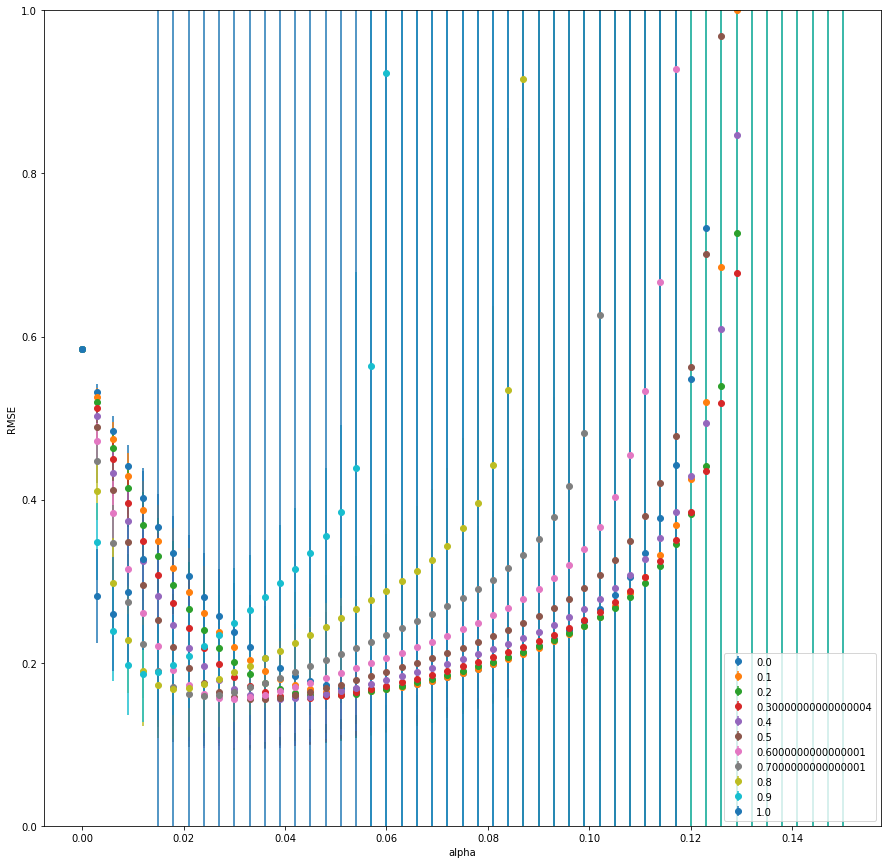

In [29]:
f, axes = plt.subplots(1, 1, figsize=(15, 15))

plt.ylim(top=1) #ymax is your value
plt.ylim(bottom=0) #ymin is your value
for i in range(0, len(lambdas), 1):
    means = np.mean(data2[i,:,:], axis  = 1)
#     print(means)
    std = np.std(data2[i,:,:], axis  = 1)
#     print(std) 
#     axes.plot(alphas, means)
#     axes.fill_between(alphas, means-std, means+std,  alpha = 0.3)
    axes.errorbar(alphas, means, yerr=std, fmt = 'o')
plt.ylim(top=1)

axes.legend(lambdas)
axes.set_xlabel('alpha')
axes.set_ylabel('RMSE')
plt.show()

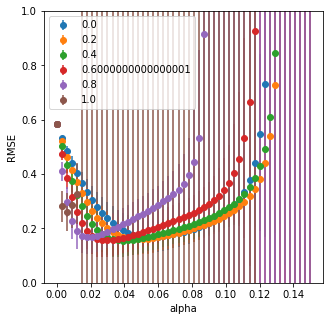

In [28]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))

plt.ylim(top=1) #ymax is your value
plt.ylim(bottom=0) #ymin is your value
for i in range(0, len(lambdas), 2):
    means = np.mean(data2[i,:,:], axis  = 1)
#     print(means)
    std = np.std(data2[i,:,:], axis  = 1)
#     print(std) 
#     axes.plot(alphas, means)
#     axes.fill_between(alphas, means-std, means+std,  alpha = 0.3)
    axes.errorbar(alphas, means, yerr=std, fmt = 'o')
plt.ylim(top=1)

axes.legend(lambdas*2)
axes.set_xlabel('alpha')
axes.set_ylabel('RMSE')
plt.show()

In [39]:
states = np.linspace(0,1, num = 21)
alphas = np.linspace(0,0.10, num = 11)
lambdas = np.linspace(0,0.8, num = 5)
data3 = np.zeros((len(lambdas),len(alphas), len(seeds)))
gamma = 1.0

In [40]:
alphas

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [45]:
b = time.perf_counter()
# for each lambda
for l, lambd in enumerate(lambdas):
    # for each alpha
    for a, alpha in enumerate(alphas): 
        # for each seed
        for run in range(0, len(seeds)):
            
            # set the seed for each run
            np.random.seed(seeds[run])

            # get the environment
            rw = env()

            # create the tilings
            t , o , width = create_tiles(rw.state_space)
            
            # initialize the weight vector
            w = np.zeros(110)
            
            # do 25 episodes of TD(lambda)
            for episode in range(0,25):
                rw.reset()
                z = np.zeros(110)

                while( 1 ):

                    s = rw.state
                    s_prime , r, _ = rw.step()

                    x_s = get_features(s, t, width).flatten()
                    V_hat_s = np.dot(w, x_s)

                    if rw.done:
                        x_s_prime = np.zeros(110)
                    else:
                        x_s_prime = get_features(s_prime, t, width).flatten()
                        
                    V_hat_s_prime = np.dot(w, x_s_prime)

                    z = gamma*lambd*z + x_s
                    delta = r + gamma*V_hat_s_prime - V_hat_s
                    w = w + alpha*delta*z

                    if rw.done == True:
                        break
            
            # after each run get the MSVE and save it
            vectorized_states = [get_features(states[i], t, width) for i in range(0, len(states))]
            estimated_values = [np.dot(w, vectorized_states[i].flatten()) for i in range(0,len(states))]
            data3[l, a, run] = np.sqrt(np.mean((states - estimated_values)**2))
            
e = time.perf_counter()

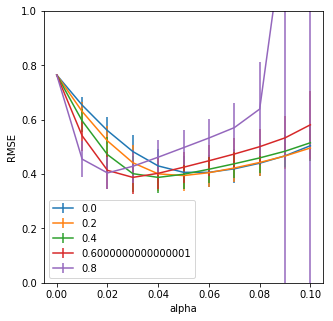

In [48]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))

plt.ylim(top=1) #ymax is your value
plt.ylim(bottom=0) #ymin is your value
for i in range(0, len(lambdas)):
    means = np.mean(np.sqrt(data3[i,:,:]), axis  = 1)
    std = np.std(data3[i,:,:], axis  = 1)
#     axes.plot(alphas, means)
#     axes.fill_between(alphas, means-std, means+std,  alpha = 0.3)
    axes.errorbar(alphas, means, yerr=std)
# plt.ylim(top=1)

axes.legend(lambdas)
axes.set_xlabel('alpha')
axes.set_ylabel('RMSE')
plt.show()

observations:


as alpha grows, the variance goes to infinity 


lower labmdas are more robust to change,


the best values are the ones in middle for both lambda and alpha